# README

Dashboards homepage : [Simple covid19 logistic regression model](https://kidpixo.github.io/COVID19-dashboard/)

This notebook output : 

- Dashboard [https://kidpixo.github.io/COVID19-dashboard/italy_covid19_logistic.html](https://kidpixo.github.io/COVID19-dashboard/italy_covid19_logistic.html)
- Noteobook [COVID19-dashboard/Logistic regression COVID-19 - Italy dataset.ipynb at master · kidpixo/COVID19-dashboard](https://github.com/kidpixo/COVID19-dashboard/blob/master/Logistic%20regression%20COVID-19%20-%20Italy%20dataset.ipynb)

Based on [Covid-19 infection in Italy. Mathematical models and predictions](https://towardsdatascience.com/covid-19-infection-in-italy-mathematical-models-and-predictions-7784b4d7dd8d)

Data from [CSSEGISandData/COVID-19](https://github.com/CSSEGISandData/COVID-19) / Dashboard [Coronavirus COVID-19 (2019-nCoV)](https://gisanddata.maps.arcgis.com/apps/opsdashboard/index.html?fbclid=IwAR3prf7gRuznOnGiv_wZpjhVQ-YZAtQcVJYorx1Yfu3Tutt4nn2dUQaGbyo#/bda7594740fd40299423467b48e9ecf6)


## requirements to run the notbook fully

    numpy
    pandas
    sklearn
    scipy
    markdown
    uncertainties
    hvplot
    holoviews


In [1]:
# useful imports
import numpy as np
np.set_printoptions(suppress=True)

import pandas as pd
# define pandas options
opts = {
  'display.width':200,
  'display.max_colwidth': 100,
  'display.max_rows': 200
        }
# set pandas options
[pd.set_option(n,o) for n,o in opts.items()]

# plotting
import matplotlib
import warnings
warnings.filterwarnings("ignore")

from matplotlib import pyplot as plt
%matplotlib inline

# useful for displaying html, images and so on
from IPython.display import display
import markdown
#  [User Guide — uncertainties Python package 3.0.1 documentation](https://pythonhosted.org/uncertainties/user_guide.html?highlight=nominal_value)
import uncertainties as un

import hvplot.pandas 
import holoviews as hv

from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve

from IPython.display import display,Markdown

doy_to_datetime = lambda x: datetime.strptime( f"2020 {int(x)}" , '%Y %j')
doy_to_datetime_vec = np.vectorize(doy_to_datetime)

# Data

## Italy Dataset

In [2]:
from urllib.request import urlopen

readme = urlopen("https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/README.md").read().decode('utf=8')
warnings = readme.partition("## Avvisi\n\n```diff")[2].partition("```")[0]

display(Markdown(warnings))


warnings_df  = pd.DataFrame.from_dict(
    { s.split(':')[0].replace('- ',''): s.split(':')[1] for s in warnings.split('\n') if s},
     orient='index')

FMT = '%d/%m/%Y'
warnings_df.index = [datetime.strptime(x, FMT) for x in warnings_df.index]

warnings_df.sort_index(inplace=True)

display(warnings_df)


- 29/03/2020: dati Regione Emilia-Romagna parziali (dato tampone non aggiornato).
- 26/03/2020: dati Regione Piemonte parziali (-50 deceduti - comunicazione tardiva).
- 18/03/2020: dati Regione Campania non pervenuti.
- 18/03/2020: dati Provincia di Parma non pervenuti.
- 17/03/2020: dati Provincia di Rimini non aggiornati.
- 16/03/2020: dati P.A. Trento e Puglia non pervenuti.
- 11/03/2020: dati Regione Abruzzo non pervenuti.
- 10/03/2020: dati Regione Lombardia parziali.
- 07/03/2020: dati Brescia +300 esiti positivi


,0
2020-03-07,dati Brescia +300 esiti positivi
2020-03-10,dati Regione Lombardia parziali.
2020-03-11,dati Regione Abruzzo non pervenuti.
2020-03-16,dati P.A. Trento e Puglia non pervenuti.
2020-03-17,dati Provincia di Rimini non aggiornati.
2020-03-18,dati Provincia di Parma non pervenuti.
2020-03-26,dati Regione Piemonte parziali (-50 deceduti - comunicazione tardiva).
2020-03-29,dati Regione Emilia-Romagna parziali (dato tampone non aggiornato).


In [3]:
# confirmed infections url
url = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"
# Deaths url
# url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv"
conf_df = pd.read_csv(url)

# fixed country
confirmed = conf_df[['totale_casi','nuovi_positivi']].copy()
confirmed.columns = ['cumulative','daily']
FMT = '%Y-%m-%dT%H:%M:%S'
confirmed.index = conf_df['data'].apply(lambda x : datetime.strptime(x, FMT))

## delete and interpolate days with warnings because data are not complete
for x in warnings_df.index:
    print(x,warnings_df.loc[x].values[0],' : Iterpolating !!')

    confirmed.loc[x.strftime('%Y-%m-%d')] = np.nan
    confirmed['daily'] = confirmed['daily'].interpolate()

# re calculate the cumulative data with the new daily rate
first_warn = warnings_df.index[0].strftime('%Y-%m-%d')
day_before_first_warn = (warnings_df.index[0]-pd.Timedelta('1 days')).strftime('%Y-%m-%d')

confirmed.loc[first_warn:,'cumulative'] = confirmed.loc[first_warn:,'daily'].cumsum()+\
                                            confirmed.loc[day_before_first_warn,'cumulative'].values[0]


# recalculate daily
confirmed['daily'] = confirmed['cumulative'].diff().fillna(0)

# confirmed = confirmed.rolling(5, win_type='gaussian').mean(std=3).dropna()

confirmed.tail(14)

2020-03-07 00:00:00  dati Brescia +300 esiti positivi  : Iterpolating !!
2020-03-10 00:00:00  dati Regione Lombardia parziali.  : Iterpolating !!
2020-03-11 00:00:00  dati Regione Abruzzo non pervenuti.  : Iterpolating !!
2020-03-16 00:00:00  dati P.A. Trento e Puglia non pervenuti.  : Iterpolating !!
2020-03-17 00:00:00  dati Provincia di Rimini non aggiornati.  : Iterpolating !!
2020-03-18 00:00:00  dati Provincia di Parma non pervenuti.  : Iterpolating !!
2020-03-26 00:00:00  dati Regione Piemonte parziali (-50 deceduti - comunicazione tardiva).  : Iterpolating !!
2020-03-29 00:00:00  dati Regione Emilia-Romagna parziali (dato tampone non aggiornato).  : Iterpolating !!


,cumulative,daily
data,,
2020-03-24 17:00:00,71258.75,5249.0
2020-03-25 17:00:00,76468.75,5210.0
2020-03-26 17:00:00,82053.25,5584.5
2020-03-27 17:00:00,88012.25,5959.0
2020-03-28 17:00:00,93986.25,5974.0
2020-03-29 17:00:00,98998.25,5012.0
2020-03-30 17:00:00,103048.25,4050.0
2020-03-31 17:00:00,107101.25,4053.0
2020-04-01 17:00:00,111883.25,4782.0


# Italy models 

In [4]:
confirmed.tail(14).hvplot()

:NdOverlay   [Variable]
   :Curve   [data]   (value)

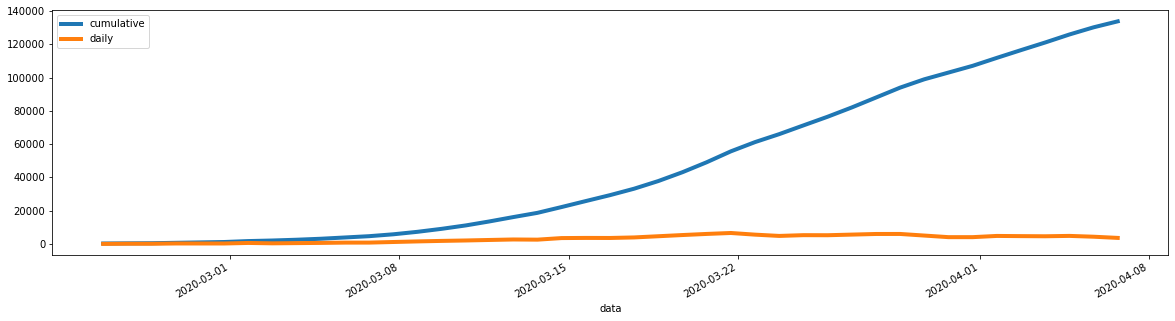

In [5]:
confirmed[['cumulative', 'daily']].plot( figsize=[20,5],lw=4);

### Time series fit

The idea is to fit the curve using only older data , from beginning to the a day N and store the result in the corresponding day N.

Daily evolving situation will update the parameters, hopefully converging at a fix set of paramter.

In [6]:
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

In [7]:
fit_time_serie = {}

n_data = confirmed.shape[0]
model_window = 13

print (
'''
a    : infection speedi
b    : the day with the maximum infections occurred
c    : the total number of recorded infected people at the infection’s end
0day :  Day of 0 new infections

''')

print(    '{:10} : {:3} {:>5} {:>4} {:>8} {:>10}'.format('date','win', 'a','b','c','0day'))
# start model_window after start
for n in confirmed.iloc[model_window:,:].index:
####### windowing the latest days
#     print(confirmed.loc[n-pd.Timedelta(f'{model_window} days'):n].shape)
    windowed = confirmed.loc[n-pd.Timedelta(f'{model_window} days'):n]
####### increasing the from start+model_window plus one day each iteration 
#     print(confirmed.loc[:n].shape)
#     windowed = confirmed.loc[n-pd.Timedelta(f'{model_window} days'):n]
    X = windowed.index.dayofyear.to_numpy()
    Y = windowed['cumulative'].values
    fit = curve_fit(logistic_model,X,Y,p0=[4,75,30000],maxfev=20000)
    ### day of 0 infections
    param = dict(zip(['a','b','c'],fit[0]))
    sol = int(fsolve(lambda x : logistic_model(x,param['a'],param['b'],param['c']) - int(param['c']),param['b']))
    fit += tuple([sol])
    print('{:10s} : {:3} {:5.3} {:4.2f} {:8.0f}  {:10s} '.format(n.strftime('%d/%m/%Y'),X.shape[0], *fit[0], doy_to_datetime(sol).strftime('%d/%m/%Y')))
    fit_time_serie[n.dayofyear] = fit


a    : infection speedi
b    : the day with the maximum infections occurred
c    : the total number of recorded infected people at the infection’s end
0day :  Day of 0 new infections


date       : win     a    b        c       0day
08/03/2020 :  14  3.85 71.86    26631  23/04/2020 
09/03/2020 :  14  4.18 76.44    62324  03/05/2020 
10/03/2020 :  14   4.3 78.67    94285  08/05/2020 
11/03/2020 :  14  4.33 78.54    90638  09/05/2020 
12/03/2020 :  14  4.27 77.43    73861  05/05/2020 
13/03/2020 :  14   4.1 75.52    53609  01/05/2020 
14/03/2020 :  14  4.18 76.15    59051  05/05/2020 
15/03/2020 :  14  4.21 76.43    61755  02/05/2020 
16/03/2020 :  14  4.19 76.38    61393  09/05/2020 
17/03/2020 :  14  4.23 76.58    63072  09/05/2020 
18/03/2020 :  14  4.38 77.39    70099  06/05/2020 
19/03/2020 :  14  4.66 78.79    83299  11/05/2020 
20/03/2020 :  14  5.04 80.80   105310  19/05/2020 
21/03/2020 :  14  5.46 83.14   136742  30/05/2020 
22/03/2020 :  14  5.58 83.64   143620  04/06/2020 
2

### The logistic model

(Text from [Covid-19 infection in Italy. Mathematical models and predictions](https://towardsdatascience.com/covid-19-infection-in-italy-mathematical-models-and-predictions-7784b4d7dd8d))

The logistic model has been widely used to describe the growth of a population. An infection can be described as the growth of the population of a pathogen agent, so a logistic model seems reasonable.

i
This formula is very known among data scientists because it’s used in the logistic regression classifier and as an activation function of neural networks.


The most generic expression of a logistic function is:

![logistic formula](https://miro.medium.com/max/546/1*bnVnrdWrWxvZfqJ_1bgrUQ.png)

In this formula, we have the variable x that is the time and three parameters: a,b,c.

- a refers to the infection speed
- b is the day with the maximum infections occurred
- c is the total number of recorded infected people at the infection’s end

At high time values, the number of infected people gets closer and closer to c and that’s the point at which we can say that the infection has ended.

This function has also an inflection point at b, that is the point at which the first derivative starts to decrease (i.e. the peak after which the infection starts to become less aggressive and decreases).



In [8]:
# from IPython.display import Markdown as md
# model paramter description 
description = {
    'a':'infection speed',
    'b':'the day with the maximum infections occurred',
    'c':'the total number of recorded infected people at the infection’s end'
}

param = dict(zip(['a','b','c'],fit[0]))

# model errror
error =dict(zip(['a','b','c'], [np.sqrt(fit[1][i][i]) for i in [0,1,2]]))

print(f"model paramter for last day { doy_to_datetime(list(fit_time_serie.keys())[-1]).strftime('%d/%m/%Y') } :")

for k in param.keys():
    out = f"   {k}: {param[k]:8.2f}±{error[k]:8.2f} : {description[k]} "
    if k == 'b' :
        out+= doy_to_datetime(param[k]).strftime('%d/%m/%Y')
    print(out)

print(f"Day of 0 new infections {doy_to_datetime(fit[-1]).strftime('%d/%m/%Y')}")


model paramter for last day 06/04/2020 :
   a:     8.12±    0.42 : infection speed 
   b:    86.56±    0.49 : the day with the maximum infections occurred 26/03/2020
   c: 170318.44± 5133.68 : the total number of recorded infected people at the infection’s end 
Day of 0 new infections 09/07/2020


In [9]:
# calculate new dates from last data point to sol
pred_dates = pd.date_range(doy_to_datetime(list(fit_time_serie.keys())[-1]+1),doy_to_datetime(sol), freq='D')
# generate a predicted df
pred_df = pd.DataFrame(index=pred_dates)
# set daily = np.nan
pred_df['daily'] = np.nan

# add to original df only if not yet there
if pred_df.index[0] not in confirmed.index:
    confirmed = confirmed.append(pred_df)

# calculate logistic_model model on the input days + future forecast
confirmed[['predicted']] = confirmed[['daily']].apply(lambda x: logistic_model(x.index.dayofyear,fit[0][0],fit[0][1],fit[0][2]) ,axis=0)

In [10]:
un_logistic_model = np.vectorize(un.wrap(logistic_model))
a_un,b_un,c_un = [un.ufloat(coeff,err) for coeff,err in zip(fit[0],np.sqrt(fit[1][np.arange(3),np.arange(3)]))] 
confirmed['predicted_un'] = un_logistic_model(confirmed.index.dayofyear,a_un,b_un,c_un)
# daily predicted increase
confirmed['predicted_daily_un'] = confirmed['predicted_un'].diff().fillna(0)

# build plot data
confirmed['predicted_daily'] = confirmed['predicted_daily_un'].map(un.nominal_value)
confirmed['predicted_daily+error'] = confirmed['predicted_daily_un'].map(lambda x: (un.nominal_value(x)-un.std_dev(x)))
confirmed['predicted_daily-error'] = confirmed['predicted_daily_un'].map(lambda x: (un.nominal_value(x)+un.std_dev(x)))

confirmed['predicted'] = confirmed['predicted_un'].map(un.nominal_value)
confirmed['predicted+error'] = confirmed['predicted_un'].map(lambda x: (un.nominal_value(x)-un.std_dev(x)))
confirmed['predicted-error'] = confirmed['predicted_un'].map(lambda x: (un.nominal_value(x)+un.std_dev(x)))

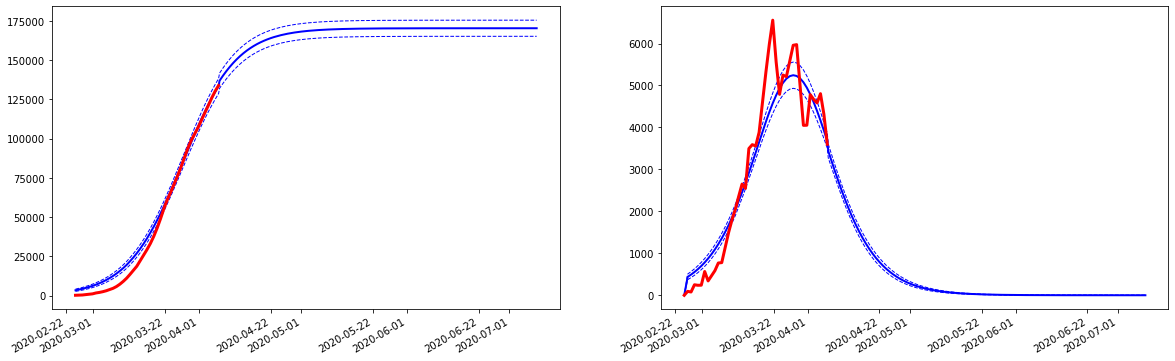

In [11]:
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=[20,9])

ax = confirmed[['predicted','predicted+error', 'predicted-error']].plot(lw=2,figsize=[20,10/1.61803398875],color='b',legend=None,ax=axs[0]);
confirmed[['cumulative']].plot(lw=3,color='red',ax=ax,legend=None);
for c in ax.lines:
    if 'error' in c.get_label():
        c.set_linestyle( '--')
        c.set_linewidth(1)
        

ax = confirmed[['predicted_daily','predicted_daily+error', 'predicted_daily-error']].plot(lw=2,figsize=[20,10/1.61803398875],color='b',legend=None, ax=axs[1]);
confirmed[['daily']].plot(lw=3,color='red',ax=ax,legend=None);
for c in ax.lines:
    if 'error' in c.get_label():
        c.set_linestyle( '--')
        c.set_linewidth(1)

In [12]:
# convert uncertainties back to numpy types
fit_time_serie_df = pd.DataFrame.from_dict(
    {k:(*v[0],*[np.sqrt(v[1][i][i]) for i in [0,1,2]],doy_to_datetime(v[-1])) for k,v in fit_time_serie.items()},
    orient='index')

fit_time_serie_df.columns = ['speed','max-day','total-infected', 'speed_error','max-day_error','total-infected_error','0-infection-day']

fit_time_serie_df.index = [datetime.strptime( f"2020 {int(k)}" , '%Y %j') for k in fit_time_serie_df.index]

for c in ['speed', 'max-day', 'total-infected']:
    fit_time_serie_df[f'{c}+error'] = fit_time_serie_df[f'{c}']+fit_time_serie_df[f'{c}_error'] 
    fit_time_serie_df[f'{c}-error'] = fit_time_serie_df[f'{c}']-fit_time_serie_df[f'{c}_error']


# convert max-day to datetime
c = 'max-day'
fit_time_serie_df[[c,f'{c}-error',f'{c}+error']] = fit_time_serie_df[[c,f'{c}-error',f'{c}+error']].apply(doy_to_datetime_vec).tail(14)
# fill Not a Time with first data point date
fit_time_serie_df = fit_time_serie_df.fillna(fit_time_serie_df.index[0])

# fit_time_serie_df.tail(14)

speed speed-error speed+error
max-day max-day-error max-day+error
total-infected total-infected-error total-infected+error


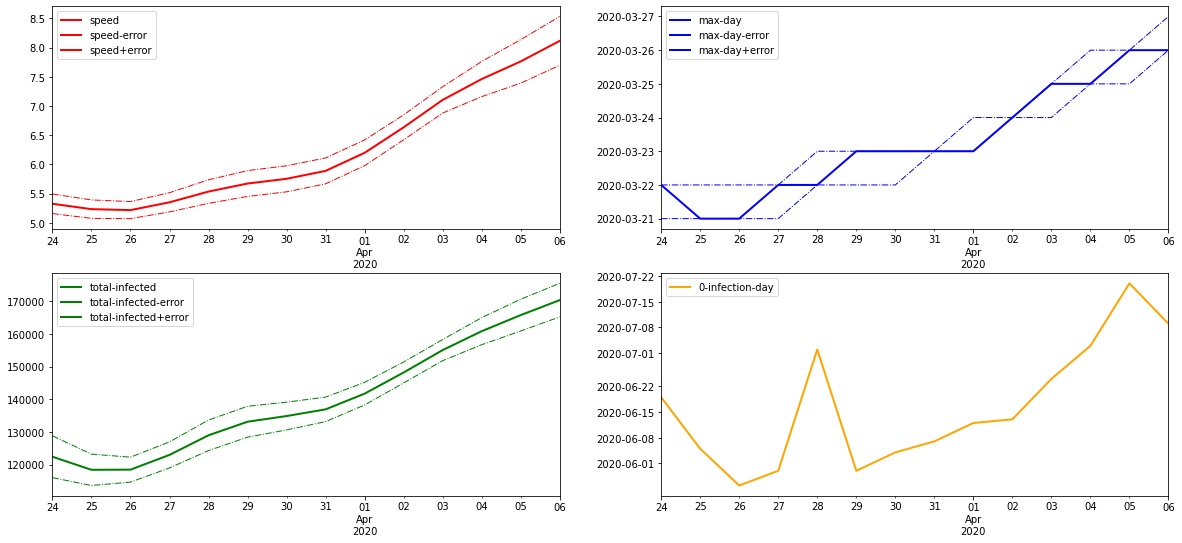

In [13]:
fig, axs = plt.subplots(nrows=2,ncols=2,figsize=[20,9])
ax = iter(axs.flatten())

colors = {'speed':'r', 'max-day':'b', 'total-infected':'g'}

for c in ['speed', 'max-day', 'total-infected']:
    print(c,f'{c}-error',f'{c}+error')
    out = fit_time_serie_df.tail(14)[[c,f'{c}-error',f'{c}+error']].plot(ax=next(ax),lw=2,color=colors[c]);
    for c in out.lines:
        if 'error' in c.get_label():
            c.set_linestyle( '-.')
            c.set_linewidth(1)

fit_time_serie_df.tail(14)[['0-infection-day']].plot(ax=next(ax),lw=2,color='orange');

In [14]:
%%opts Curve {-axiswise}
%%opts Curve [height=250, width=500]

##################### Cumulative
opts_dict = {
'predicted'      : {'line_width':4, 'color':'blue'},
'predicted+error': {'line_width':2, 'color':'blue','line_dash':'dashed'},
'predicted-error': {'line_width':2, 'color':'blue','line_dash':'dashed'},
'cumulative':                 {'line_width':4, 'color':'red'}
}

cumulative_overlay = hv.Overlay( [confirmed[p].hvplot(legend=False,title='Infection / data+predicted / cumulative').opts(**opts_dict[p]) for p in opts_dict.keys()] )

##################### Daily 
opts_dict = {
'predicted_daily'      : {'line_width':4, 'color':'blue'},
'predicted_daily+error': {'line_width':2, 'color':'blue','line_dash':'dashed'},
'predicted_daily-error': {'line_width':2, 'color':'blue','line_dash':'dashed'},
'daily':                 {'line_width':4, 'color':'red'}
}

daily_overlay =  hv.Overlay( [confirmed[p].hvplot(legend=False,title='Infection / data+predicted / daily').opts(**opts_dict[p]) for p in opts_dict.keys()] )
        
##################### model paramter evolution         
outVerlay = []

colors = {
    'speed'           : 'orange',
    'max-day'         : 'cyan',
    'total-infected'  : 'green',
}

for c in ['speed', 'max-day', 'total-infected']:
#     print(c,f'{c}-error',f'{c}+error')
    opts_dict = {
                c : {'line_width':4, 'color': colors[c]},
                f'{c}-error' : {'line_width':2, 'color':colors[c],'line_dash':'dashed'},
                f'{c}+error': {'line_width':2, 'color': colors[c],'line_dash':'dashed'},
                }

    outVerlay.append(hv.Overlay( [fit_time_serie_df[p].hvplot(legend=False,title=f'Infection {c}').opts(**opts_dict[p]) for p in opts_dict.keys()] ))

outVerlay.append(fit_time_serie_df['0-infection-day'].hvplot(title='Day of 0 Infection').opts(line_width=2, color='black'))
    
paramter_evolution = hv.Layout(outVerlay)


dashboard = (cumulative_overlay+daily_overlay+paramter_evolution).cols(2)

renderer = hv.renderer('bokeh')

# Using renderer save
renderer.save(dashboard, 'docs/italy_covid19_logistic')

# dashboard

In [15]:
print(f"model paramter for last day { doy_to_datetime(list(fit_time_serie.keys())[-1]).strftime('%d/%m/%Y') } :")

latest_model_results = [] 
for k in param.keys():
    out = f"   {k}: {param[k]:8.2f}±{error[k]:8.2f} : {description[k]} "
    if k == 'b' :
        out+= doy_to_datetime(param[k]).strftime('%d/%m/%Y')
    latest_model_results.append('-' + out)
latest_model_results.append(f"- Day of 0 new infections {doy_to_datetime(fit[-1]).strftime('%d/%m/%Y')}")


print('\n'.join(latest_model_results))

model paramter for last day 06/04/2020 :
-   a:     8.12±    0.42 : infection speed 
-   b:    86.56±    0.49 : the day with the maximum infections occurred 26/03/2020
-   c: 170318.44± 5133.68 : the total number of recorded infected people at the infection’s end 
- Day of 0 new infections 09/07/2020


In [16]:
with open('index.md') as file:
    data_md = file.read()

data_md = data_md.format(last_date= doy_to_datetime(list(fit_time_serie.keys())[-1]).strftime('%d/%m/%Y') ,
                  latest_model_results='\n'.join(latest_model_results))

In [17]:
with open('index.html') as file:
    data_html = file.read()

md = markdown.Markdown()

data_html = data_html.format(body=md.convert(data_md))

with open('docs/index.html','w') as file:
    file.write(data_html)